# Decision Trees

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from datetime import datetime

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Agenda

SWBAT:

- Describe the decision tree modeling algorithm;
- Use attribute selection methods to build different trees;
- Explain the pros and cons of decision trees;
- Interpret the feature importances of a fitted model.

## Decision Trees at a High Level

<img src='./img/titanic_tree.png' width=600/>

A decision tree is a machine learning model that works by partitioning our sample space in a hierarchical way.

How do we partition the space? The key idea is that some attributes provide more information than others when trying to make a decision.

### Trump lawsuit data

In [2]:
df = pd.read_csv('data/trump_train.csv',
                 usecols=['dateFiled', 'type', 'issue'])
df

,dateFiled,type,issue
0,11/30/17,2,Mueller investigation
1,8/14/18,1,Mueller investigation
2,1/24/19,1,Mueller investigation
3,12/17/18,2,Emoluments
4,6/12/17,2,Emoluments
5,7/11/17,2,First Amendment


### Partitioning

I partition my data by asking a question about the independent variables. The goal is to ask the right questions in the right order so that the resultant groups are "pure" with respect to the dependent variable. Let's say that the dependent variable in this case is whether the case is type 1 (criminal) or type 2 (civil).

Suppose, for example, that I choose:

#### Was the case filed before October 2018?

This would divide my data into two groups:

- Group 1 (filed before):

data points: 0, 1, 4, 5

- Group 2 (filed after):

data points: 2, 3

#### Key Question: How are the values of the target distributed in this group?

In Group 1, I have: civil, criminal, civil, civil

In Group 2, I have: criminal, civil

This seems like an ok split:

  - The first group has a majority of civil cases (3/4), so it suggests that earlier cases are unlikely to be criminal.
  - But the second group has one of each type, so that doesn't give us much information.

Would a different question split our data more effectively? Let's try:

#### Does the case concern the Mueller investigation?

Let's look at our splits:

- Group 1 (Mueller cases):

data points: 0, 1, 2

- Group 2 (Other cases):

data points: 3, 4, 5

#### Key Question again: Distribution of target

In Group 1, I have: civil, criminal, criminal

In Group 2, I have: civil, civil, civil

That seems better:

  - Group 2 is a pure group! All cases outside the Mueller investigation were civil cases.
  - Group 1 has two criminal cases and only one civil case.
  
A (very simple!) model that predicts "criminal" for Mueller cases and "civil" otherwise would correctly classify five of these six data points!

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?  

## Entropy/Information Gain and Gini

The goal is to have our ultimate classes be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma^n_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group, where $n$ is the number of groups (i.e. target values).

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

<img src='./img/Entropy_mapped.png' width=600/>

In the present case we have only two groups of interest: criminal and civil.

Four out of six were civil and two out of six were criminal, so **these are the relevant probabilities** for our calculation of entropy.

So our entropy for the sample above is:

$-\frac{2}{3}*\log_2\left(\frac{2}{3}\right) - \frac{1}{3}*\log_2\left(\frac{1}{3}\right)$.

Let's use ``numpy's`` `log2()` function to calculate this:

In [3]:
-(2/3) * np.log2(2/3) - (1/3) * np.log2(1/3)

0.9182958340544896

That's a high level of disorder!

### Entropy of a Split

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our "was the case filed before October 2018?" question:

Group 1 (filed before): civil, criminal, civil, civil

$E_{g1} = -\frac{3}{4} * \log_2(\frac{3}{4}) - \frac{1}{4} * \log_2(\frac{1}{4})$. 

Group 2 (filed after): criminal, civil

$E_{g2} = -\frac{1}{2} * \log_2\left(\frac{1}{2}\right) - \frac{1}{2} * \log_2\left(\frac{1}{2}\right)$.

In [4]:
ent_before = -(3/4)*np.log2(3/4) - (1/4)*np.log2(1/4)
print(ent_before)

ent_after = -(1/2)*np.log2(1/2) - (1/2)*np.log2(1/2)
print(ent_after)

0.8112781244591328
1.0


Now weight those by the probability of each group, and sum them, to find the entropy of the split:

In [5]:
before_norm = (4/6) * ent_before
after_norm = (2/6) * ent_after

E_split_d = before_norm + after_norm
E_split_d

0.8741854163060885

Not great. Compare that to the Mueller question:

In [6]:
# In Group 1: civil, criminal, criminal

ent_mueller = -(2/3)*np.log2(2/3) - (1/3)*np.log2(1/3)
print(ent_mueller)

# In Group 2: civil, civil, civil

ent_other = -(3/3)*np.log2(3/3) # Pure group!
print(ent_other)

0.9182958340544896
-0.0


In [10]:
ent_other_2 = np.log2(0/3)  # Pure group!
# print(ent_other_2)

<ipython-input-10-30288d451409>:1: RuntimeWarning: divide by zero encountered in log2
  ent_other_2 = np.log2(0/3)  # Pure group!


Weighted sum

In [11]:
mueller_norm = ent_mueller * 3/6
other_norm = ent_other * 3/6

E_split_m = mueller_norm + other_norm
E_split_m

0.4591479170272448

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

In [12]:
total_entropy_sample = -(4/6)*np.log2(4/6) - (2/6)*np.log2(2/6)


# Information gain: before or after October 2018

ig_d = total_entropy_sample - E_split_d
print(f"Information gain for Oct. 2018 split: {ig_d}")

# Information gain: Mueller-related or not

ig_m = total_entropy_sample - E_split_m
print(f"Information gain for Mueller split: {ig_m}")

Information gain for Oct. 2018 split: 0.044110417748401076
Information gain for Mueller split: 0.4591479170272448


For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us!

Moreover, we can **iterate** this algorithm on the resultant groups until we reach pure groups!

**Question**: Are we in fact guaranteed, proceeding in this way, to reach pure groups, no matter what our data looks like?  
Ans: No

**Observation**: This algorithm looks for the best split **locally**. There is no regard for how an overall tree might look. That's what makes this algorithm ***greedy***.

### Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_ip_i^2$, or, equivalently, $\large G = \Sigma_ip_i(1-p_i)$.

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

## Regression

We can also use decision trees for regression problems. How does the regressor work? Information gain and Gini impurity make sense only for discrete classes. What we need for a continuous target is some measure of the *spread* of those values, and so the natural move here is to split our groups in ways that will most *reduce the standard deviation of those groups*. For more on this, see [here](https://www.saedsayad.com/decision_tree_reg.htm).

## With `sklearn`

In [13]:
# This will turn dates into numbers!

df['dateFiled'] = pd.to_datetime(df['dateFiled']).map(lambda x: x.date().toordinal())

# And this will convert the issue to numbers:

df['issue'] = df['issue'].map(lambda x: 1 if x == 'Mueller investigation' else 0)

In [14]:
df['type'].value_counts()

2    4
1    2
Name: type, dtype: int64

In [20]:
df

,dateFiled,type,issue
0,736663,2,1
1,736920,1,1
2,737083,1,1
3,737045,2,0
4,736492,2,0
5,736521,2,0


In [18]:
dt = DecisionTreeClassifier(criterion='entropy')

X = df.drop('type', axis=1)
y = df.type
dtree = dt.fit(X, y)

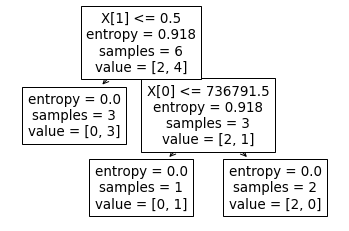

In [19]:
plot_tree(dt);

In [21]:
# April 7, 2018 is halfway between the points that differ in type

datetime.fromordinal(736791)

datetime.datetime(2018, 4, 7, 0, 0)

### Important Terminology related to Decision Trees

- **Root Node:** Represents entire population or sample.
- **Decision Node:** Node that is split.
- **Leaf/ Terminal Node:** Node with no children.
- **Pruning:** Removing nodes.
- **Branch / Sub-Tree:** A sub-section of a decision tree.
- **Parent and Child Node:** A node divided into sub-nodes is the parent; the sub-nodes are its children.

<img src='./img/decision_leaf.webp' width=600 />

## Challenges with Decision Trees

### Decision trees are prone to overfitting

In [22]:
df_test = pd.read_csv('data/trump-lawsuits.csv',
                     usecols=['dateFiled', 'type', 'issue']).iloc[[5, 17, 20, 25], :]
df_test

,dateFiled,type,issue
5,11/28/18,1,Mueller investigation
17,8/19/16,1,Pardons
20,3/15/16,1,Whitaker dispute
25,5/31/19,2,Census


In [23]:
# Accuracy on training data
dt.score(X, y)

1.0

In [30]:
# Dates to numbers

df_test['dateFiled'] = pd.to_datetime(df_test['dateFiled'])\
.map(lambda x: x.date().toordinal())

# And this will convert the issue to numbers:

df_test['issue'] = df_test['issue']\
.map(lambda x: 1 if x == 'Mueller investigation' else 0)

X_test = df_test.drop('type', axis=1)
y_test = df_test.type

In [31]:
# Accuracy on test data
dt.score(X_test, y_test)

0.25

### Bias-Variance with Decision Trees

The CART algorithm will repeatedly partition data into smaller and smaller subsets until those final subsets are homogeneous in terms of the outcome variable. In practice this often means that the final subsets (known as the leaves of the tree) each consist of only one or a few data points. 

This tends to result in low-bias, high variance models.

### Stopping Criterion - Pruning Parameters

The recursive binary splitting procedure described above needs to know when to stop splitting as it works its way down the tree with the training data.

**min_samples_leaf:**  The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

**max_leaf_nodes:** 
Reduce the number of leaf nodes.

**max_depth:**
Reduce the depth of the tree to build a generalized tree.

**min_impurity_split :**
A node will split if its impurity is above the threshold, otherwise it will be a leaf.


## Feature Importances

The fitted tree has an attribute called `ct.feature_importances_`. What does this mean? Roughly, the importance (or "Gini importance") of a feature is a sort of weighted average of the impurity decrease at internal nodes that make use of the feature. The weighting comes from the number of samples that depend on the relevant nodes.

> The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. See [`sklearn`'s documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_).

In [32]:
dt = DecisionTreeClassifier()

dt.fit(X, y)

for fi, feature in zip(dt.feature_importances_, X.columns):
    print(fi, feature)

0.5 dateFiled
0.5 issue


More on feature importances [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3).

## Conclusions

- The decision tree is a "white-box" type of ML algorithm. It shares internal decision-making logic, which is not available in the black-box type of algorithms such as Neural Network.
- Its training time is faster compared to other algorithms such as neural networks.
- The decision tree is a non-parametric method, which does not depend upon probability distribution assumptions.
- Decision trees can handle high-dimensional data with good accuracy.

### Pros

Decision trees:
- are easy to interpret and to visualize;
- can easily capture non-linear patterns;
- require little data preprocessing from the user. For example, there is no need to normalize columns;
- can be used for feature engineering such as predicting missing values, suitable for variable selection;
- make no assumptions about distribution, because of the non-parametric nature of the algorithm;

### Cons

Decision trees:
- are sensitive to noisy data. This problem can be significantly ameliorated by ensemble methods.
- produce high-bised models with imbalanced datasets (so it is recommended that you balance out the dataset before creating the decision tree).